In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from waymo_open_dataset import dataset_pb2 as open_dataset

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Waymo SDK Imported ✅")


2026-01-16 19:18:52.810905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 19:18:53.340190: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 19:18:53.432738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-01-16 19:18:53.432767: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

TensorFlow: 2.11.0
NumPy: 1.26.4
Matplotlib: 3.6.1
Waymo SDK Imported ✅


In [2]:
TRAIN_DIR = "/home/kakani/waymo_project/1_data/tfrecords/training"
VAL_DIR   = "/home/kakani/waymo_project/1_data/tfrecords/validation"

print("Train folder:", TRAIN_DIR)
print("Validation folder:", VAL_DIR)

print("\nTraining files:", os.listdir(TRAIN_DIR)[:5])
print("Validation files:", os.listdir(VAL_DIR)[:5])


Train folder: /home/kakani/waymo_project/1_data/tfrecords/training
Validation folder: /home/kakani/waymo_project/1_data/tfrecords/validation

Training files: ['segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord']
Validation files: ['segment-10203656353524179475_7625_000_7645_000_with_camera_labels.tfrecord']


In [3]:
train_files = sorted([
    os.path.join(TRAIN_DIR, f)
    for f in os.listdir(TRAIN_DIR)
    if f.endswith(".tfrecord")
])

if len(train_files) == 0:
    raise FileNotFoundError("❌ No tfrecord found inside training folder!")

TRAIN_FILE = train_files[0]
print("✅ Selected TRAIN_FILE:", TRAIN_FILE)


✅ Selected TRAIN_FILE: /home/kakani/waymo_project/1_data/tfrecords/training/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord


In [4]:
dataset = tf.data.TFRecordDataset(TRAIN_FILE, compression_type="")
print("✅ TFRecordDataset Loaded")


✅ TFRecordDataset Loaded


2026-01-16 19:19:49.086610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-16 19:19:49.086897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-01-16 19:19:49.087958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2026-01-16 19:19:49.088410: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2026-01-16 19:19:49.088843: W tensorf

In [5]:
for data in dataset.take(1):
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    print("✅ Frame parsed successfully")
    break

print("\nFrame context name:", frame.context.name)
print("Timestamp micros:", frame.timestamp_micros)
print("No. of images:", len(frame.images))
print("No. of camera labels:", len(frame.camera_labels))


✅ Frame parsed successfully

Frame context name: 10017090168044687777_6380_000_6400_000
Timestamp micros: 1550083467346370
No. of images: 5
No. of camera labels: 5


In [6]:
camera_id_map = {
    1: "FRONT",
    2: "FRONT_LEFT",
    3: "FRONT_RIGHT",
    4: "SIDE_LEFT",
    5: "SIDE_RIGHT"
}

camera_names = [img.name for img in frame.images]
print("Available Camera IDs:", camera_names)

for cid in camera_names:
    print(cid, "->", camera_id_map.get(cid, "UNKNOWN"))


Available Camera IDs: [1, 2, 4, 3, 5]
1 -> FRONT
2 -> FRONT_LEFT
4 -> SIDE_LEFT
3 -> FRONT_RIGHT
5 -> SIDE_RIGHT


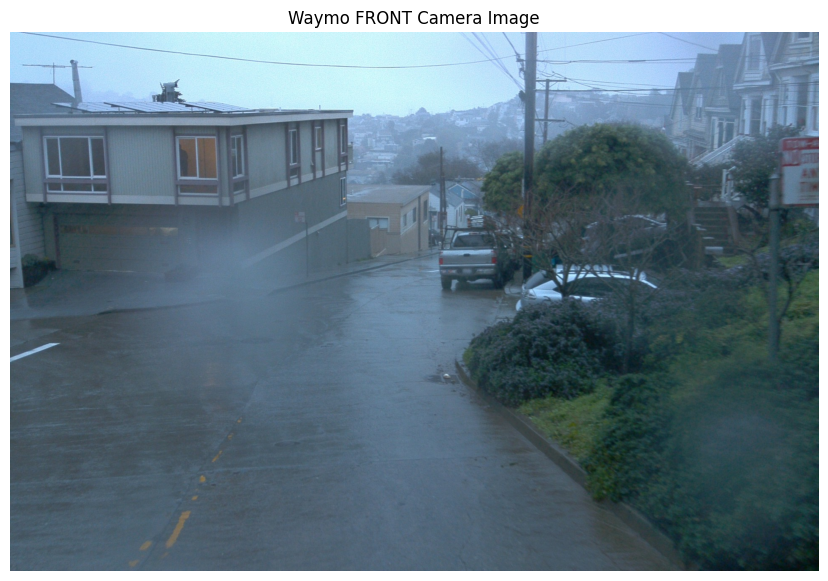

In [7]:
target_camera = open_dataset.CameraName.FRONT

front_img = None
for img in frame.images:
    if img.name == target_camera:
        front_img = img
        break

if front_img is None:
    raise ValueError("❌ FRONT camera image not found!")

img_np = tf.image.decode_jpeg(front_img.image).numpy()

plt.figure(figsize=(12, 7))
plt.imshow(img_np)
plt.title("Waymo FRONT Camera Image")
plt.axis("off")
plt.show()


In [8]:
print("Total camera labels available:", len(frame.camera_labels))

for lbl in frame.camera_labels:
    print("Camera:", camera_id_map.get(lbl.name, "UNKNOWN"),
          "| Total Labels:", len(lbl.labels))


Total camera labels available: 5
Camera: FRONT | Total Labels: 5
Camera: FRONT_LEFT | Total Labels: 2
Camera: SIDE_LEFT | Total Labels: 0
Camera: FRONT_RIGHT | Total Labels: 0
Camera: SIDE_RIGHT | Total Labels: 0


In [9]:
label_map = {
    1: "VEHICLE",
    2: "PEDESTRIAN",
    3: "SIGN",
    4: "CYCLIST"
}


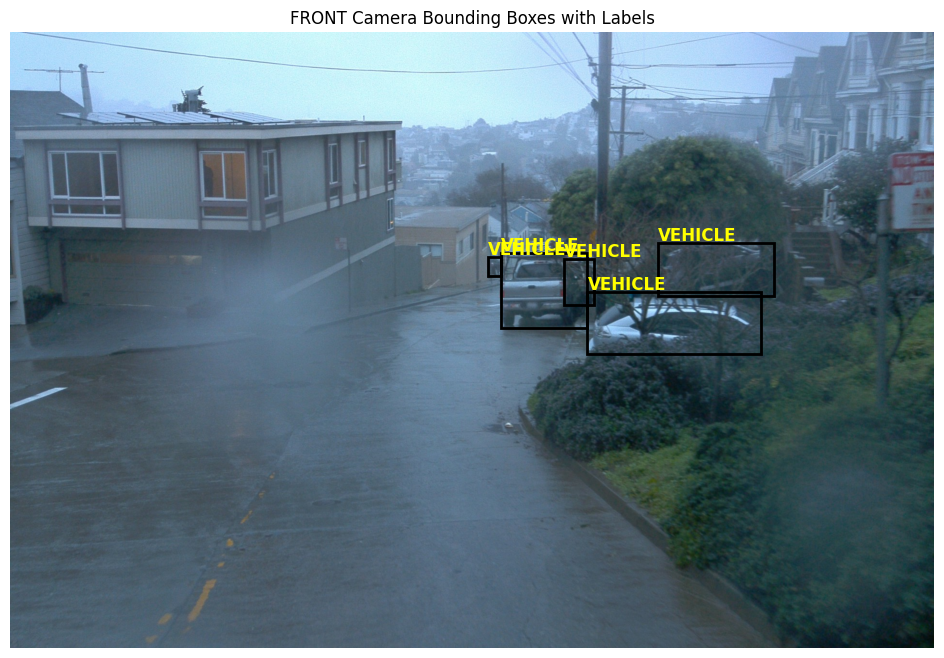

In [10]:
plt.figure(figsize=(14, 8))
plt.imshow(img_np)
plt.axis("off")
plt.title("FRONT Camera Bounding Boxes with Labels")

for cam_lbl in frame.camera_labels:
    if cam_lbl.name == target_camera:
        for label in cam_lbl.labels:
            box = label.box
            cx, cy, w, h = box.center_x, box.center_y, box.length, box.width
            x1, y1 = cx - w/2, cy - h/2

            rect = patches.Rectangle((x1, y1), w, h,
                                     fill=False, linewidth=2)
            plt.gca().add_patch(rect)

            obj_type = label_map.get(label.type, "UNKNOWN")
            plt.text(x1, y1 - 5, obj_type, color="yellow",
                     fontsize=12, weight="bold")

plt.show()


In [11]:
print("✅ STEP 5 COMPLETED SUCCESSFULLY 🔥")
print("TFRecord Loaded ✅")
print("Frame Parsed ✅")
print("Image Displayed ✅")
print("Bounding Boxes + Labels Drawn ✅")


✅ STEP 5 COMPLETED SUCCESSFULLY 🔥
TFRecord Loaded ✅
Frame Parsed ✅
Image Displayed ✅
Bounding Boxes + Labels Drawn ✅
